In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')

from sklearn.manifold import TSNE
from scipy import stats
import pickle

Make sure to have the classes in the same directory as the notebook for it to work.

In [3]:
import class_DataProcessor, class_SeriesAnalyser, class_Trader

series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Data Import

In [21]:
df2 = pd.read_excel('./data/120_ETFs_2018_to_2022.xlsx')
df2.Date = pd.to_datetime(df2.Date)
df2.set_index('Date', inplace=True)
df2.sort_index(inplace=True)
for col in df2:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

In [ ]:
tickers = df2.columns.tolist()

with open('./data/tickers.pickle', 'wb') as f:
    pickle.dump(tickers, f)

# Preprocessing

In [23]:
# Fill upto 5 consecutive NaNs through linear interpolation
df2 = df2.interpolate(method='linear', limit=5)

# If NaNs persist beyond that, drop those tickers
df2 = data_processor.remove_tickers_with_nan(df2, 0)

In [24]:
# split data in training and test
form_period_start = '01-02-2018'
form_period_end = '31-12-2021'
trade_period_start = '01-03-2022'
trade_period_end = '30-12-2022'
df_prices_train, df_prices_test = data_processor.split_data(df2,
                                                            (form_period_start,
                                                             form_period_end),
                                                            (trade_period_start,
                                                             trade_period_end),
                                                            remove_nan=True)

print(f"\nThe training set contains {df_prices_train.shape[0]} records, ranging from {df_prices_train.index[0]} to {df_prices_train.index[-1]}.")
print(f"The test set contains {df_prices_test.shape[0]} records, ranging from {df_prices_test.index[0]} to {df_prices_test.index[-1]}.")

Total of 71 tickers
Total of 71 tickers after removing tickers with Nan values

The training set contains 78240 records, ranging from 2018-01-02 09:30:00 to 2021-12-30 15:55:00.
The test set contains 19465 records, ranging from 2022-01-03 09:30:00 to 2022-12-29 15:55:00.


# Clustering with Unsupervised Learning

## 1. Calculate returns of training set

In [25]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns

,TQQQ,SQQQ,SOXL,SPY,LABU,QQQ,FXI,EEM,SH,SOXS,...,ACWX,SCHE,SPYG,EWU,DGRO,IXUS,VYM,SCHX,EWW,SPLV
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 09:35:00,0.008349,-0.009139,0.012075,0.001209,0.015483,0.002934,0.001158,0.001779,-0.001161,-0.008605,...,-0.000197,0.000956,0.001207,-0.000280,0.000026,0.001215,0.000378,0.001101,-0.003061,-0.000627
2018-01-02 09:40:00,0.005594,-0.005478,0.007141,0.000099,0.014310,0.001732,-0.000314,-0.000417,0.000000,-0.011779,...,0.000794,-0.000332,0.001512,-0.000280,0.000032,0.000362,-0.000378,0.000287,-0.002466,-0.000660
2018-01-02 09:45:00,0.003726,-0.004047,0.004821,-0.000522,-0.003498,0.001402,-0.000213,-0.000105,0.000497,-0.003971,...,-0.000197,-0.000020,0.000029,-0.000694,-0.001434,-0.000631,-0.000864,-0.000471,0.003128,-0.001858
2018-01-02 09:50:00,0.001263,-0.001195,0.001506,0.000168,-0.002154,0.000445,0.000000,-0.000105,-0.000332,-0.001625,...,0.000002,-0.000178,0.000271,0.000000,0.000097,0.000159,-0.000011,-0.000567,-0.001208,-0.001053
2018-01-02 09:55:00,0.004173,-0.005025,0.003104,0.000953,0.000539,0.001335,0.000000,-0.000210,-0.000998,-0.003211,...,-0.000002,-0.000085,-0.000029,0.000138,0.001112,0.000366,0.000993,0.001367,0.000101,0.001033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 15:35:00,-0.002453,0.002610,-0.002876,-0.000147,-0.014308,-0.000834,0.000000,0.000204,0.000370,0.002895,...,-0.000090,0.000169,-0.000683,-0.000149,0.000361,-0.000069,0.000345,-0.000262,-0.000790,0.000439
2021-12-30 15:40:00,-0.002985,0.002203,-0.001441,-0.000744,-0.000484,-0.000996,-0.000676,-0.000508,0.000711,0.001578,...,-0.000449,-0.000505,-0.000890,0.000000,-0.000539,-0.000493,-0.000434,-0.000786,0.001286,-0.000657
2021-12-30 15:45:00,-0.001527,0.002267,-0.002593,-0.000430,0.001829,-0.000461,-0.001486,-0.000713,0.000400,0.001486,...,-0.000628,-0.000840,-0.000614,-0.000302,-0.000270,-0.000422,-0.000356,-0.000524,0.000296,-0.000073


In [26]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  2485.0


## 2. Apply PCA

In [27]:
N_PRIN_COMPONENTS = 5
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns, 
                                                  random_state=0)#12)
print(explained_variance)

[4.74387475e-04 1.44648163e-04 4.87129856e-05 3.02658955e-05
 1.62288727e-05]


## 3. Unsupervised clustering

In [36]:
def apply_clustering(X, df_returns, method='optics', eps=5, min_samples=3, n_clusters_hierarchical=12):
  if method.lower() == 'optics':
    clustered_series_all, clustered_series, counts, clf = series_analyser.apply_OPTICS(X, df_returns, min_samples=min_samples, max_eps=eps)
  elif method.lower() == 'dbscan':
    clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(eps=eps, min_samples=min_samples, X=X, df_returns=df_returns)
  else:
    clustered_series_all, clustered_series, counts, clf = series_analyser.apply_hierarchical_clustering(X, df_returns, n_clusters=n_clusters_hierarchical)
  return clustered_series_all, clustered_series, counts, clf

def cluster_size(counts, title):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    plt.title(title)
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('ETFs within cluster')
    plt.ylabel('Cluster Id');

### 3.1 Generate pairs from DBSCAN clusters

DBSCAN Clusters:
Clusters discovered: 4
Pairs to evaluate: 117


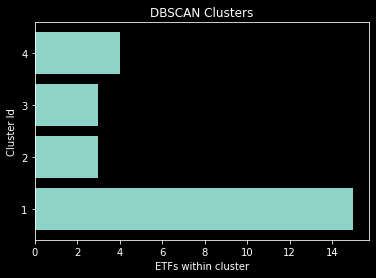

In [38]:
print("DBSCAN Clusters:")
dbscan_clustered_series_all, dbscan_clustered_series, dbscan_counts, dbscan_clf = apply_clustering(X=X,
                                                                                                   df_returns=df_returns,
                                                                                                   method='dbscan',
                                                                                                   eps=0.15,
                                                                                                   min_samples=3)
cluster_size(dbscan_counts, 'DBSCAN Clusters')

### 3.2 Generate pairs from OPTICS clusters

OPTICS Clusters:
OPTICS(max_eps=5, metric='euclidean', min_samples=3)
Clusters discovered: 7
Pairs to evaluate: 52


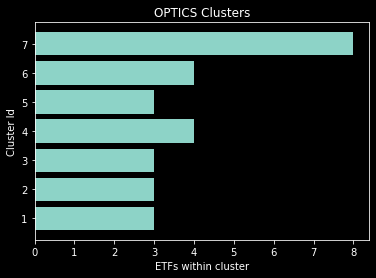

In [39]:
print("OPTICS Clusters:")
optics_clustered_series_all, optics_clustered_series, optics_counts, optics_clf = apply_clustering(X=X,
                                                                                                   df_returns=df_returns,
                                                                                                   min_samples=3,
                                                                                                   eps=5)
cluster_size(optics_counts, 'OPTICS Clusters')

### 3.3 Generate pairs from Hierarchical clusters

Hierarchical Clusters:
Clusters discovered: 11
Pairs to evaluate: 955


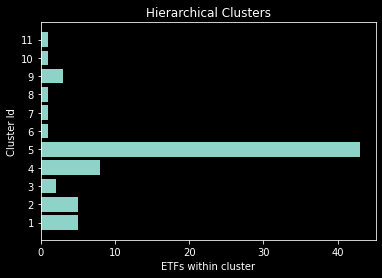

In [41]:
print("Hierarchical Clusters:")
hier_clustered_series_all, hier_clustered_series, hier_counts, hier_clf = apply_clustering(X=X,
                                                                                           df_returns=df_returns,
                                                                                           method='hierarchical',
                                                                                           n_clusters_hierarchical=11)
cluster_size(hier_counts, 'Hierarchical Clusters')

# Pair Selection

Now that the clusters have been identified, we find cointegrated pairs within each of the clusters subject to some criteria such as:
- p-value threshold
- a minimum number of zero crossings
- minimum and maximum half life
- subsample
 - if the subsample is not specified, then the code will take the whole data into consideration to identify the pairs, resulting in a significantly longer runtime
 - at the same time if the subsample is too small, it may not be representative of the whole population

## OPTICS Pairs Generation

In [44]:
# The half-life of mean-reversion is an indicator of how long it takes for a time series to mean-revert.
# We propose filtering out pairs for which the half-life takes extreme values: less than one day or more than one year.
print("OPTICS Pairs:")

subsample = 2500
min_half_life = 78 # number of points in a day
max_half_life = 20000 #~number of points in a year: 78*252
min_zero_crosings = 12

pairs_unsupervised_optics, unique_tickers_optics = series_analyser.get_candidate_pairs(clustered_series=optics_clustered_series,
                                                                                       pricing_df_train=df_prices_train,
                                                                                       pricing_df_test=df_prices_test,
                                                                                       min_half_life=min_half_life,
                                                                                       max_half_life=max_half_life,
                                                                                       min_zero_crosings=min_zero_crosings,
                                                                                       p_value_threshold=0.05,
                                                                                       hurst_threshold=0.5)

# Save the pairs for trading
with open('./data/pairs_optics.pickle', 'wb') as f:
    pickle.dump(pairs_unsupervised_optics, f)

Cluster 7/7Found 17 pairs
The pairs contain 17 unique tickers
Pairs Selection failed stage:  {'cointegration': 25, 'None': 17, 'half_life': 4, 'hurst_exponent': 6}


## Hierarchical Pairs Generation

In [ ]:
# The half-life of mean-reversion is an indicator of how long it takes for a time series to mean-revert.
# We propose filtering out pairs for which the half-life takes extreme values: less than one day or more than one year.
print("Hierarchical Pairs:")

subsample = 2500
min_half_life = 78 # number of points in a day
max_half_life = 20000 #~number of points in a year: 78*252
min_zero_crosings = 12

pairs_unsupervised_hier, unique_tickers_hier = series_analyser.get_candidate_pairs(clustered_series=hier_clustered_series,
                                                                                   pricing_df_train=df_prices_train,
                                                                                   pricing_df_test=df_prices_test,
                                                                                   min_half_life=min_half_life,
                                                                                   max_half_life=max_half_life,
                                                                                   min_zero_crosings=12,
                                                                                   p_value_threshold=0.05,
                                                                                   hurst_threshold=0.5)

# Save the pairs for trading
with open('./data/pairs_hierarchical.pickle', 'wb') as f:
    pickle.dump(pairs_unsupervised_hier, f)

Cluster 12/12Found 85 pairs
The pairs contain 50 unique tickers
Pairs Selection failed stage:  {'cointegration': 841, 'hurst_exponent': 23, 'half_life': 4, 'None': 83}
